In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.stats import rankdata

## Load Data

In [2]:
train_clean = joblib.load('data/train_clean.pckl')
test_clean = joblib.load('data/test_clean.pckl')

X_tfidf = joblib.load('data/X_tfidf.pckl')
X_svd = joblib.load('data/X_svd.pckl')

X_test_tfidf = joblib.load('data/X_test_tfidf.pckl')
X_test_svd = joblib.load('data/X_test_svd.pckl')

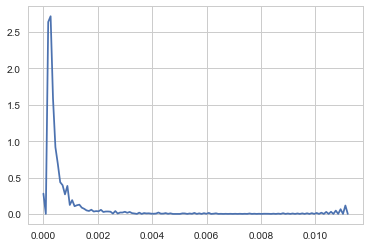

In [33]:
x1 = np.array(X_tfidf.mean(axis=0)).reshape(2605661,)
x2 = X_svd.mean(axis=0).reshape(100,)
sns.kdeplot(x)

## SGD

In [49]:
# tune a few hyperparameters

params = {'loss': ['log','modified_huber'],
          'penalty': ['l1','l2','elasticnet']}

cv_results = dict()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    sgd = SGDClassifier()

    estimator = GridSearchCV(sgd, 
                            params,
                            scoring='roc_auc',
                            n_jobs=3,
                            cv=StratifiedKFold(5))

    estimator.fit(X_tfidf, train_clean[target])
    
    cv_results[target] = estimator.cv_results_
    
    best_auc = np.max(estimator.cv_results_['mean_test_score'])
    best_params = estimator.cv_results_['params'][np.argmax(estimator.cv_results_['mean_test_score'])]
    
    print(target.upper(), round(best_auc,4), best_params)

TOXIC 0.9724 {'loss': 'modified_huber', 'penalty': 'l2'}
SEVERE_TOXIC 0.9856 {'loss': 'modified_huber', 'penalty': 'l2'}
OBSCENE 0.989 {'loss': 'modified_huber', 'penalty': 'l2'}
THREAT 0.9836 {'loss': 'modified_huber', 'penalty': 'l2'}
INSULT 0.9793 {'loss': 'modified_huber', 'penalty': 'l2'}
IDENTITY_HATE 0.9768 {'loss': 'modified_huber', 'penalty': 'l2'}


In [3]:
params = {'loss': ['log','modified_huber'],
          'penalty': ['l1','l2','elasticnet',None]}

cv_results = dict()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    sgd = SGDClassifier()

    estimator = GridSearchCV(sgd, 
                            params,
                            scoring='roc_auc',
                            n_jobs=3,
                            cv=StratifiedKFold(5))

    estimator.fit(X_svd, train_clean[target])
    
    cv_results[target] = estimator.cv_results_
    
    best_auc = np.max(estimator.cv_results_['mean_test_score'])
    best_params = estimator.cv_results_['params'][np.argmax(estimator.cv_results_['mean_test_score'])]
    
    print(target.upper(), round(best_auc,4), best_params)

TOXIC 0.931 {'loss': 'modified_huber', 'penalty': 'elasticnet'}
SEVERE_TOXIC 0.9805 {'loss': 'log', 'penalty': 'l2'}
OBSCENE 0.9673 {'loss': 'modified_huber', 'penalty': 'elasticnet'}
THREAT 0.9294 {'loss': 'modified_huber', 'penalty': 'l2'}
INSULT 0.948 {'loss': 'modified_huber', 'penalty': 'elasticnet'}
IDENTITY_HATE 0.9371 {'loss': 'modified_huber', 'penalty': 'l2'}


## Final Model Fit/Scoring

In [5]:
# consistent folds to use for stacking
skf = StratifiedKFold(n_splits=10, random_state=678246569, shuffle=True)

In [7]:
sgd = SGDClassifier(loss='modified_huber',
                   penalty='l2')

sgd_train_scores = train_clean[['id']].copy()
sgd_test_scores = test_clean[['id']].copy()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    sgd_train_scores[target] = np.nan
    sgd_test_scores[target] = np.nan
    
    # train and score cv models for stacking
    for train, test in skf.split(X_tfidf, train_clean[target]):
        sgd.fit(X_tfidf[train, :], train_clean.loc[train, target])
        sgd_train_scores.loc[test, target] = sgd.predict_proba(X_tfidf[test, :])[:,1]

    # train full model and score on test data
    sgd.fit(X_tfidf, train_clean[target])
    sgd_test_scores[target] = sgd.predict_proba(X_test_tfidf)[:,1]
    
    print('Finished - ',target.upper())

Finished -  TOXIC
Finished -  SEVERE_TOXIC
Finished -  OBSCENE
Finished -  THREAT
Finished -  INSULT
Finished -  IDENTITY_HATE


In [9]:
joblib.dump(sgd_train_scores, 'data/sgd_train_cv_scores.pckl')
sgd_test_scores.to_csv('data/S8_sgd.csv', index=False)

In [10]:
sgd_test_scores.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.000000,0.238143,1.000000,0.065663,0.874376,0.193759
1,0000247867823ef7,0.000000,0.000000,0.000000,0.000000,0.003897,0.000000
2,00013b17ad220c46,0.060771,0.000000,0.024736,0.000000,0.026572,0.000000
3,00017563c3f7919a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,00017695ad8997eb,0.055873,0.000000,0.013332,0.000000,0.020367,0.000000


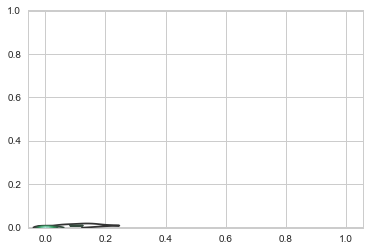

In [12]:
sns.kdeplot(sgd_test_scores[['toxic','severe_toxic']])

## Stack with Previous Logistic Model

In [14]:
stack_train = joblib.load('data/stacking_train.pckl')

In [53]:
target = 'toxic'

# orig scores
temp = pd.concat([stack_train['LOG_'+target], 
                  stack_train['LDA_'+target],
                  stack_train['NB_'+target],
                  sgd_train_scores[target],
                  train_clean[target]], axis=1)
temp.columns = ['LOG', 'LDA', 'NB', 'SGD', target]

# score ranks
temp2 = temp.copy()
for c in ['LOG', 'LDA', 'NB', 'SGD']:
    temp2[c] = rankdata(temp2[c])

# standardized scores
temp3 = temp.copy()
scalers = dict()
scalers[target] = StandardScaler()
temp3[['LOG', 'LDA', 'NB', 'SGD']] = scalers[target].fit_transform(temp3[['LOG', 'LDA', 'NB', 'SGD']])

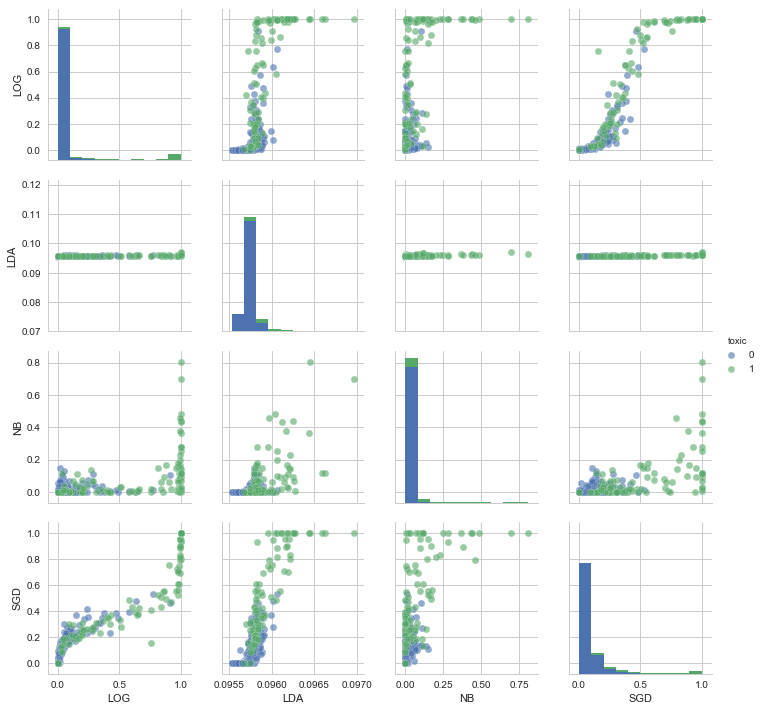

In [50]:
sns.pairplot(temp.sample(1000, axis=0), 
             vars=['LOG', 'LDA', 'NB', 'SGD'],
             hue=target,
             plot_kws=dict(alpha=.6))

In [73]:
for s in ['LOG', 'LDA', 'NB', 'SGD']:
    fpr, tpr, thresholds = roc_curve(temp['toxic'], temp[s], pos_label=1)
    rocauc = auc(fpr, tpr)
    print(s, round(rocauc,6))
    
print()
fpr, tpr, thresholds = roc_curve(temp['toxic'], (temp['LOG']+temp['SGD']), pos_label=1)
rocauc = auc(fpr, tpr)
print(round(rocauc,6))

LOG 0.973212
LDA 0.926361
NB 0.849002
SGD 0.972384

0.973541


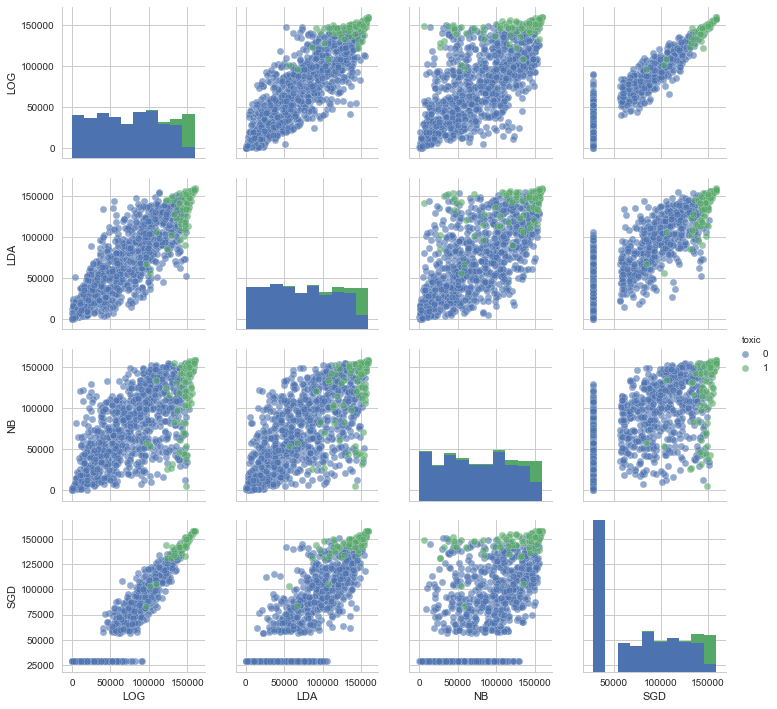

In [46]:
sns.pairplot(temp2.sample(1000, axis=0), 
             vars=['LOG', 'LDA', 'NB', 'SGD'],
             hue=target,
             plot_kws=dict(alpha=.6))

In [76]:
for s in ['LOG', 'LDA', 'NB', 'SGD']:
    fpr, tpr, thresholds = roc_curve(temp2['toxic'], temp2[s], pos_label=1)
    rocauc = auc(fpr, tpr)
    print(s, round(rocauc,6))
    
print()
fpr, tpr, thresholds = roc_curve(temp2['toxic'], (temp2['LOG']+temp2['SGD']), pos_label=1)
rocauc = auc(fpr, tpr)
print(round(rocauc,6))

LOG 0.973212
LDA 0.926361
NB 0.849002
SGD 0.972384

0.97364


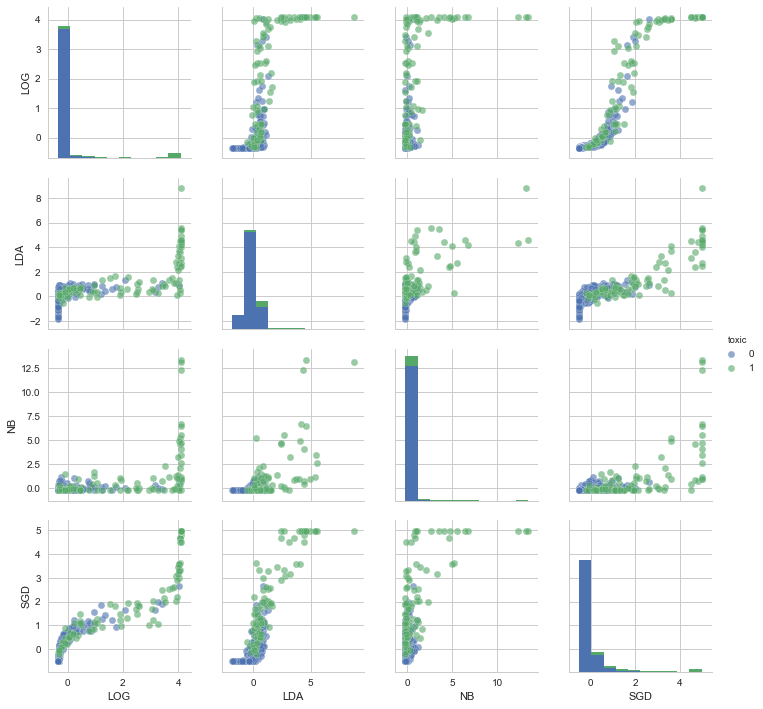

In [54]:
sns.pairplot(temp3.sample(1000, axis=0), 
             vars=['LOG', 'LDA', 'NB', 'SGD'],
             hue=target,
             plot_kws=dict(alpha=.6))

In [71]:
fpr, tpr, thresholds = roc_curve(temp['toxic'], (temp['LOG']+temp['SGD']), pos_label=1)
rocauc = auc(fpr, tpr)
print(round(rocauc,6))

0.973541


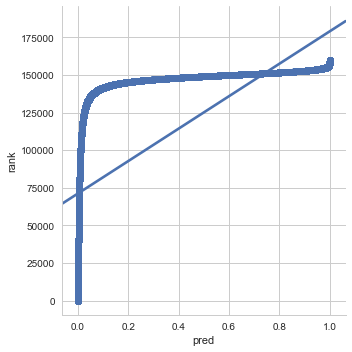

In [93]:
lmdata = pd.concat([temp['LOG'], temp2['LOG']], axis=1)
lmdata.columns = ['pred', 'rank']
lmdata.sort_values('rank', inplace=True)
sns.lmplot('pred', 'rank', lmdata)

In [85]:
from scipy.interpolate import interp1d

In [94]:
f2 = interp1d(lmdata['pred'], lmdata['rank'], kind='cubic')
f2

ValueError: Expect x to be a 1-D sorted array_like.

In [92]:
lmdata

,pred,rank
10,0.000001,1.0
70830,0.000002,2.0
26289,0.000002,3.0
27389,0.000002,4.0
15119,0.000002,5.5
113524,0.000002,5.5
66508,0.000002,7.0
36096,0.000002,8.0
80237,0.000002,9.0
136660,0.000002,10.0


In [ ]:
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(min(x), max(x), num=50, endpoint=True)
plt.plot(x, y, 'o', xnew, f2(xnew), '--')
plt.legend(['raw',  'cubic spline'], loc='best')
plt.title('C Tuning Curve: '+target)
plt.axis('tight')
plt.xlabel('C (max @ %0.1f)' % x[np.argmax(y)])
plt.ylabel('AUC')
plt.show()